In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

# Send a request to the webpage
url = "https://www.ncaa.com/history/volleyball-women/d1"
response = requests.get(url)

# Parse the webpage content
soup = BeautifulSoup(response.content, 'html.parser')

# Find the table containing the championship data
table = soup.find('table')

# Initialize dictionaries to count the wins and runner-ups for each team
team_wins = defaultdict(int)
team_runner_ups = defaultdict(int)

# Iterate through each row in the table
for row in table.find_all('tr')[1:]:  # Skip header row
    cols = row.find_all('td')
    if len(cols) > 1:
        # Extract champion team name (ignore record in parentheses)
        champion = cols[1].get_text(strip=True).split(' (')[0]
        # Extract runner-up team name (ignore record in parentheses)
        runner_up = cols[4].get_text(strip=True).split(' (')[0]
        
        # Count the wins and runner-ups
        team_wins[champion] += 1
        team_runner_ups[runner_up] += 1

# Aggregating wins and runner-ups across different records for the same team
aggregated_wins = defaultdict(int)
aggregated_runner_ups = defaultdict(int)

# Aggregating the wins and runner-ups
for team, wins in team_wins.items():
    team_name = team.split('(')[0]  # Remove any record details in parentheses
    aggregated_wins[team_name] += wins

for team, runner_ups in team_runner_ups.items():
    team_name = team.split('(')[0]  # Remove any record details in parentheses
    aggregated_runner_ups[team_name] += runner_ups

# Prepare data for visualization
teams = list(aggregated_wins.keys())
wins = [aggregated_wins[team] for team in teams]
runner_ups = [aggregated_runner_ups[team] for team in teams]

# Calculate final appearances (wins + runner-ups) and win percentages
final_appearances = np.array(wins) + np.array(runner_ups)
win_percentages = np.array(wins) / final_appearances * 100


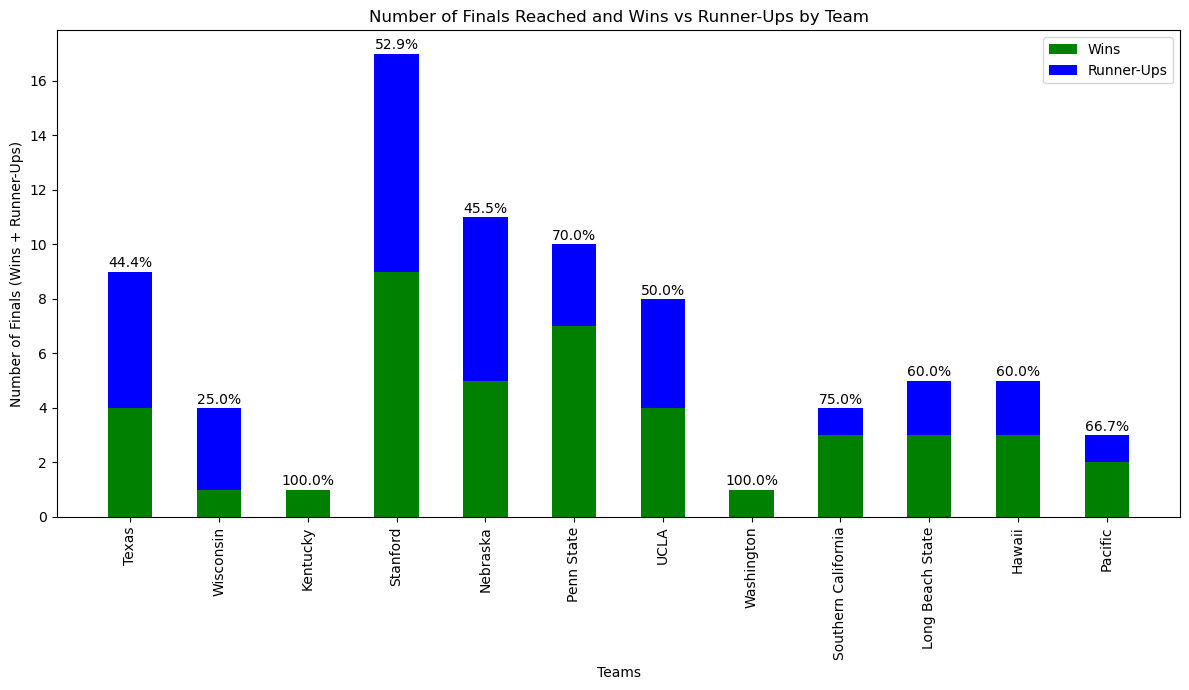

In [2]:

# Plot Stacked Bar Chart (Wins vs Runner-Ups)
fig, ax = plt.subplots(figsize=(12, 7))

# Create a stacked bar chart
bar_width = 0.5
indices = np.arange(len(teams))
ax.bar(indices, wins, bar_width, label='Wins', color='green')
ax.bar(indices, runner_ups, bar_width, bottom=wins, label='Runner-Ups', color='blue')

# Customize the chart
ax.set_xlabel('Teams')
ax.set_ylabel('Number of Finals (Wins + Runner-Ups)')
ax.set_title('Number of Finals Reached and Wins vs Runner-Ups by Team')
ax.set_xticks(indices)
ax.set_xticklabels(teams, rotation=90)
ax.legend()

# Show win percentages on top of bars
for i in range(len(teams)):
    ax.text(indices[i], wins[i] + runner_ups[i] + 0.05, f'{win_percentages[i]:.1f}%', ha='center', va='bottom')

# Show the stacked bar chart
plt.tight_layout()
plt.show()




Stacked Bar Chart: Wins vs Runner-Ups by Team: This chart displays the number of finals each team reached, with green bars representing wins and blue bars representing runner-ups. The height of each bar indicates the team's total finals appearances, and win percentages are shown above the bars.



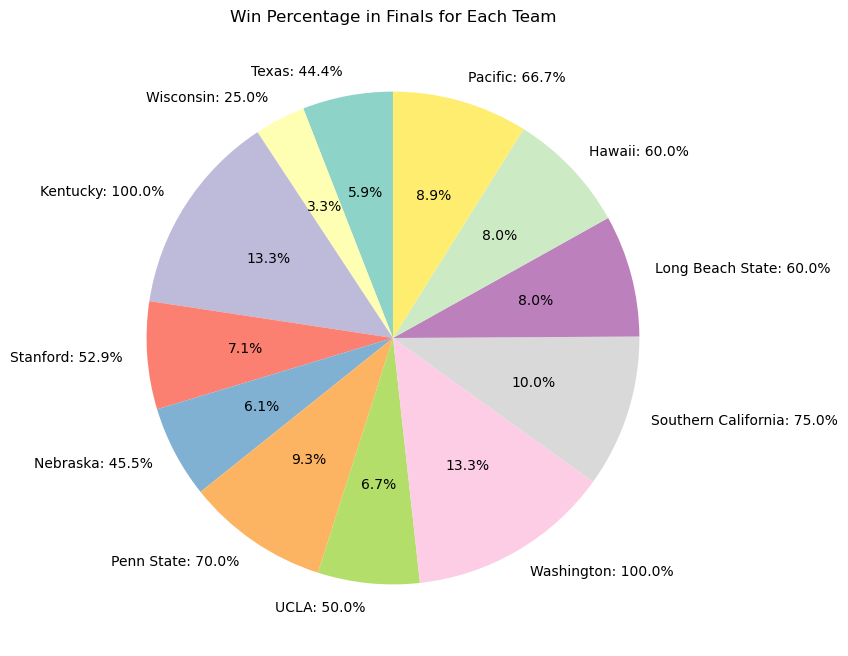

In [3]:
# Pie Chart for Win Percentages
fig, ax = plt.subplots(figsize=(8, 8))

# Create a pie chart for win percentages
win_percentage_labels = [f"{team}: {win_percentages[i]:.1f}%" for i, team in enumerate(teams)]
ax.pie(win_percentages, labels=win_percentage_labels, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set3", len(teams)))
ax.set_title('Win Percentage in Finals for Each Team')

# Show the pie chart
plt.show()

Pie Chart: Win Percentage in Finals
This pie chart shows each team's win percentage in finals. The size of each segment corresponds to the win percentage, with labels displaying the team's name and their win percentage.

In [5]:
# URL for the NCAA volleyball rankings page
url = "https://www.ncaa.com/rankings/volleyball-women/d1/ncaa-womens-volleyball-rpi"

# Step 1: Fetch the webpage content
response = requests.get(url)
if response.status_code != 200:
    print("Failed to fetch the webpage. Check the URL or your connection.")
    exit()

# Step 2: Parse the HTML content
soup = BeautifulSoup(response.text, 'html.parser')

# Step 3: Locate the rankings table
table = soup.find('table')  # Locate the first table on the page
if not table:
    print("No table found on the page. Verify the webpage structure.")
    exit()

# Step 4: Extract table headers
headers = [header.text.strip() for header in table.find_all('th')]

# Step 5: Extract table rows
rows = table.find_all('tr')[1:]  # Skip the header row
data = []
for row in rows:
    cols = [col.text.strip() for col in row.find_all('td')]
    if cols:  # Ensure it's not an empty row
        data.append(cols)

# Step 6: Convert to Pandas DataFrame
df = pd.DataFrame(data, columns=headers)

# Step 7: Convert the Rank column to numeric and clean data
df['Rank'] = pd.to_numeric(df['Rank'], errors='coerce')
df = df.dropna(subset=['Rank']).reset_index(drop=True)

# Step 8: Get the top 5 and bottom 5 teams
top_5 = df.head(5)
bottom_5 = df.tail(5)

# Display results
print("Top 5 Teams:")
print(top_5[['Rank', 'School']])  # Changed 'Team' to 'School'

print("\nBottom 5 Teams:")
print(bottom_5[['Rank', 'School']])  # Changed 'Team' to 'School'


Top 5 Teams:
   Rank      School
0     1    Nebraska
1     2  Pittsburgh
2     3  Louisville
3     4    Penn St.
4     5    Stanford

Bottom 5 Teams:
     Rank           School
341   342    Saint Peter's
342   343            Siena
343   344        Manhattan
344   345  Ark.-Pine Bluff
345   346           Alcorn


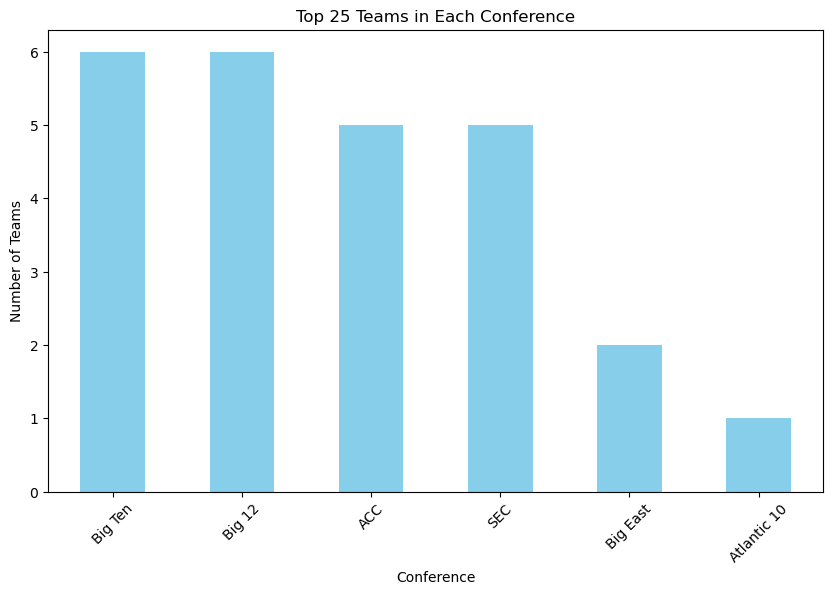

In [6]:
# Step 1: Get the top 25 teams
top_25 = df.head(25)

# Step 2: Group by conference
conference_counts = top_25['Conference'].value_counts()

# Step 3: Plot the bar chart
plt.figure(figsize=(10, 6))
conference_counts.plot(kind='bar', color='skyblue')
plt.title('Top 25 Teams in Each Conference')
plt.xlabel('Conference')
plt.ylabel('Number of Teams')
plt.xticks(rotation=45)
plt.show()


The chart provides insights into how many top teams belong to each conference, making it easier to compare the strength of conferences based on the number of top-ranked teams.



In [7]:
def scrape_stat(url):
    # Step 1: Fetch the webpage content
    response = requests.get(url)
    if response.status_code != 200:
        print("Failed to fetch the webpage. Check the URL or your connection.")
        return None

    # Step 2: Parse the HTML content
    soup = BeautifulSoup(response.text, 'html.parser')

    # Step 3: Locate the rankings table
    table = soup.find('table')  # Locate the first table on the page
    if not table:
        print("No table found on the page. Verify the webpage structure.")
        return None

    # Step 4: Extract table headers
    headers = [header.text.strip() for header in table.find_all('th')]

    # Step 5: Extract table rows
    rows = table.find_all('tr')[1:]  # Skip the header row
    data = []
    for row in rows:
        cols = [col.text.strip() for col in row.find_all('td')]
        if cols:  # Ensure it's not an empty row
            data.append(cols)

    # Step 6: Convert to Pandas DataFrame
    df = pd.DataFrame(data, columns=headers)

    # Step 7: Clean up the DataFrame (optional: remove empty rows, etc.)
    return df

# URLs for different statistics
urls = {
    'Aces Per Set': 'https://www.ncaa.com/stats/volleyball-women/d1/current/team/48',
    'Assists Per Set': 'https://www.ncaa.com/stats/volleyball-women/d1/current/team/47',
    'Blocks Per Set': 'https://ncaa.com/stats/volleyball-women/d1/current/team/49',
    'Digs Per Set': 'https://www.ncaa.com/stats/volleyball-women/d1/current/team/50',
    'Hitting Percentage': 'https://www.ncaa.com/stats/volleyball-women/d1/current/team/45',
    'Kills Per Set': 'https://www.ncaa.com/stats/volleyball-women/d1/current/team/46',
    'Opp Hitting Percentage': 'https://www.ncaa.com/stats/volleyball-women/d1/current/team/911'
}

# Scrape all statistics
all_stats = {}
for stat_name, url in urls.items():
    print(f"Scraping {stat_name}...")
    df = scrape_stat(url)
    if df is not None:
        all_stats[stat_name] = df

# Displaying the top 5 teams for each stat
for stat_name, df in all_stats.items():
    print(f"\nTop 5 {stat_name}:\n", df.head(5))


Scraping Aces Per Set...
Scraping Assists Per Set...
Scraping Blocks Per Set...
Scraping Digs Per Set...
Scraping Hitting Percentage...
Scraping Kills Per Set...
Scraping Opp Hitting Percentage...

Top 5 Aces Per Set:
   Rank           Team    S Aces Per Set
0    1  Saint Francis   99  252    2.55
1    2           UTEP  111  253    2.28
2    3         Mercer  120  257    2.14
3    4           FGCU  114  244    2.14
4    5    Florida A&M  111  234    2.11

Top 5 Assists Per Set:
   Rank        Team    S Assists Per Set
0    1  Wright St.  108    1494   13.83
1    2    Missouri  100    1365   13.65
2    3      Kansas   92    1253   13.62
3    4         UNI  109    1482   13.60
4    5    Penn St.  103    1394   13.53

Top 5 Blocks Per Set:
   Rank            Team    S Block Solos Block Assists Per Set
0    1       Wisconsin   96          36           519    3.08
1    2      Louisville   96          70           448    3.06
2    3          Oregon   96          53           471    3.01
3   

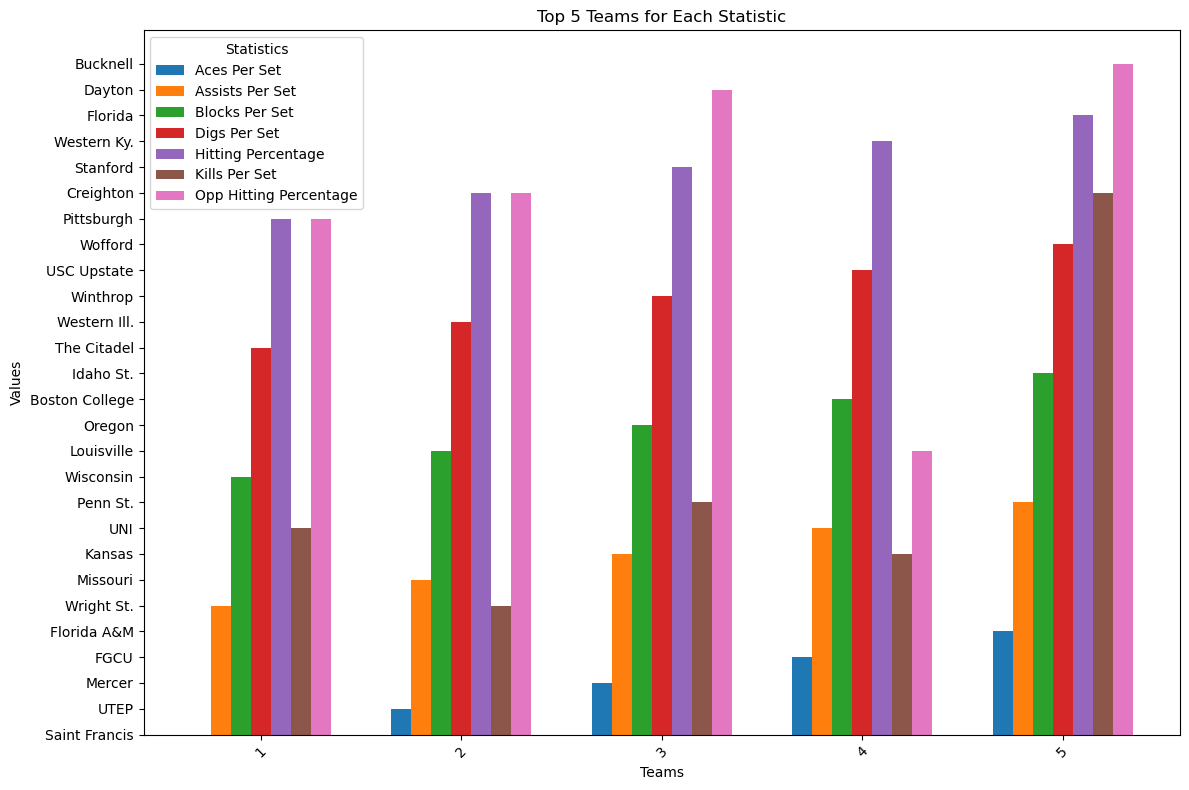

In [8]:
# Initialize the figure
plt.figure(figsize=(12, 8))

# Set the width of each bar
bar_width = 0.1

# Get the list of teams from the first stat (assuming all stats have the same teams)
teams = all_stats['Aces Per Set'].iloc[:, 0].head(5)  # Get top 5 teams (adjust if necessary)

# Initialize an index for the x-axis
indices = np.arange(len(teams))

# Loop through the statistics and plot each stat as a bar
for i, (stat_name, df) in enumerate(all_stats.items()):
    stat_values = df.head(5).iloc[:, 1]  # Get the top 5 values for the statistic
    plt.bar(indices + i * bar_width, stat_values, bar_width, label=stat_name)  # Shift bars for each stat

# Customize the chart
plt.title('Top 5 Teams for Each Statistic')
plt.xlabel('Teams')
plt.ylabel('Values')
plt.xticks(indices + bar_width * len(all_stats) / 2 - bar_width / 2, teams, rotation=45)
plt.legend(title='Statistics')

# Show the plot
plt.tight_layout()
plt.show()


The bar chart displays the performance of the top 5 volleyball teams across multiple statistics, allowing for an easy visual comparison of their strengths and weaknesses across various metrics. Including Aces Per Set, Assists Per Set, Blocks Per Set, and more. Each team is represented on the x-axis, and the corresponding statistic values are shown on the y-axis. 



In [9]:
def scrape_stat(url):
    # Step 1: Fetch the webpage content
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to fetch the webpage {url}. Check the URL or your connection.")
        return None

    # Step 2: Parse the HTML content
    soup = BeautifulSoup(response.text, 'html.parser')

    # Step 3: Locate the rankings table
    table = soup.find('table')  # Locate the first table on the page
    if not table:
        print("No table found on the page. Verify the webpage structure.")
        return None

    # Step 4: Extract table headers
    headers = [header.text.strip() for header in table.find_all('th')]

    # Step 5: Extract table rows
    rows = table.find_all('tr')[1:]  # Skip the header row
    data = []
    for row in rows:
        cols = [col.text.strip() for col in row.find_all('td')]
        if cols:  # Ensure it's not an empty row
            data.append(cols)

    # Step 6: Convert to Pandas DataFrame
    df = pd.DataFrame(data, columns=headers)

    # Step 7: Clean up the DataFrame (optional: remove empty rows, etc.)
    return df

def get_teams_stats(all_stats, team_names):
    # Filter for provided team names in each stat
    teams_stats = {}
    for stat_name, df in all_stats.items():
        if 'Team' in df.columns:
            # Filter for teams whose names are in the provided team_names list
            filtered_teams_df = df[df['Team'].str.contains('|'.join(team_names), case=False, na=False)]
            if not filtered_teams_df.empty:
                teams_stats[stat_name] = filtered_teams_df
        else:
            print(f"Warning: No 'Team' column found for {stat_name}.")
    
    return teams_stats

# List of teams to scrape stats for
team_names = [
    'Texas', 'Stanford', 'Wisconsin', 'Nebraska', 'Louisville',
    'Florida', 'Pittsburgh', 'Kentucky', 'Ohio State', 'Minnesota',
    'Oregon', 'BYU', 'UCLA', 'Purdue', 'Creighton',
    'Northwestern', 'Penn State', 'Colorado St.', 'Arkansas', 'Georgia Tech',
    'Kansas', 'Baylor', 'Washington', 'Michigan', 'Iowa State', 'Missouri St.'
]


# URLs for different statistics
urls = {
    'Aces Per Set': 'https://www.ncaa.com/stats/volleyball-women/d1/current/team/48',
    'Assists Per Set': 'https://www.ncaa.com/stats/volleyball-women/d1/current/team/47',
    'Blocks Per Set': 'https://ncaa.com/stats/volleyball-women/d1/current/team/49',
    'Digs Per Set': 'https://www.ncaa.com/stats/volleyball-women/d1/current/team/50',
    'Hitting Percentage': 'https://www.ncaa.com/stats/volleyball-women/d1/current/team/45',
    'Kills Per Set': 'https://www.ncaa.com/stats/volleyball-women/d1/current/team/46',
    'Opp Hitting Percentage': 'https://www.ncaa.com/stats/volleyball-women/d1/current/team/911'
}

# Scrape all statistics
all_stats = {}
for stat_name, url in urls.items():
    print(f"Scraping {stat_name}...")
    df = scrape_stat(url)
    if df is not None:
        all_stats[stat_name] = df

# Get stats for all the provided teams
teams_stats = get_teams_stats(all_stats, team_names)

# Display each team's stats for each category
for stat_name, df in teams_stats.items():
    print(f"\n{stat_name}:\n", df)


Scraping Aces Per Set...
Scraping Assists Per Set...
Scraping Blocks Per Set...
Scraping Digs Per Set...
Scraping Hitting Percentage...
Scraping Kills Per Set...
Scraping Opp Hitting Percentage...

Aces Per Set:
    Rank               Team    S Aces Per Set
4     5        Florida A&M  111  234    2.11
6     -         Pittsburgh   90  186    2.07
10   11            Florida   96  187    1.95
13   14          Creighton   96  184    1.92
22   23           Kentucky   92  173    1.88
36   37  George Washington  115  205    1.78

Assists Per Set:
    Rank               Team    S Assists Per Set
2     3             Kansas   92    1253   13.62
5     6          Creighton   96    1289   13.43
6     7           Stanford   92    1226   13.33
8     9           Nebraska   96    1274   13.27
9    10         Pittsburgh   90    1189   13.21
11   12             Purdue  101    1330   13.17
21   22            Florida   96    1244   12.96
24   25          Texas A&M   94    1216   12.94
25   26  Purdue Fort 

In [10]:
def calculate_total_rankings(teams_stats, team_names):
    # Initialize a counter to store total rankings for each team
    total_rankings = {team: 0 for team in team_names}
    
    # Loop through all the statistics data
    for stat_name, df in teams_stats.items():
        if 'Team' in df.columns:
            # Count the occurrences of each team in the current stat and add to total rankings
            team_counts = df['Team'].str.strip().str.title().value_counts()
            for team, count in team_counts.items():
                if team in total_rankings:
                    total_rankings[team] += count
    
    # Sort teams by the total number of rankings (in descending order)
    sorted_rankings = sorted(total_rankings.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_rankings

# Calculate total rankings for each team
sorted_team_rankings = calculate_total_rankings(teams_stats, team_names)

# Display the total rankings for all top 25 teams
print("Total rankings for each team across all categories:")
for team, rank in sorted_team_rankings:
    print(f"{team}: {rank} rankings")


Total rankings for each team across all categories:
Pittsburgh: 6 rankings
Creighton: 6 rankings
Wisconsin: 5 rankings
Nebraska: 5 rankings
Florida: 4 rankings
Kentucky: 4 rankings
Purdue: 4 rankings
Kansas: 4 rankings
Stanford: 3 rankings
Louisville: 3 rankings
Oregon: 3 rankings
Colorado St.: 3 rankings
Texas: 2 rankings
Minnesota: 2 rankings
Arkansas: 1 rankings
Georgia Tech: 1 rankings
Baylor: 1 rankings
Missouri St.: 1 rankings
Ohio State: 0 rankings
BYU: 0 rankings
UCLA: 0 rankings
Northwestern: 0 rankings
Penn State: 0 rankings
Washington: 0 rankings
Michigan: 0 rankings
Iowa State: 0 rankings


In [11]:
import matplotlib.pyplot as plt

# Function to plot the total rankings as a pie chart excluding teams with zero rankings
def plot_total_rankings_pie(sorted_team_rankings):
    # Filter out teams with no rankings
    filtered_rankings = [(team, rank) for team, rank in sorted_team_rankings if rank > 0]
    
    if not filtered_rankings:
        print("No teams with rankings to display.")
        return
    
    # Extract the teams and their respective rankings
    teams = [team for team, rank in filtered_rankings]
    rankings = [rank for team, rank in filtered_rankings]

    # Create a pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(rankings, labels=teams, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors, 
            pctdistance=0.85, wedgeprops={'edgecolor': 'black'})

    # Add a title
    plt.title('Total Rankings for Teams Across All Categories')

    # Display the chart
    plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.
    plt.show()


The pie chart visually represents the total rankings for each team, with each slice corresponding to a team's ranking and the percentage of total rankings they occupy. Teams with a ranking of zero are excluded from the chart.

In [12]:
def scrape_stat(url):
    # Step 1: Fetch the webpage content
    response = requests.get(url)
    if response.status_code != 200:
        print("Failed to fetch the webpage. Check the URL or your connection.")
        return None

    # Step 2: Parse the HTML content
    soup = BeautifulSoup(response.text, 'html.parser')

    # Step 3: Locate the rankings table
    table = soup.find('table')  # Locate the first table on the page
    if not table:
        print("No table found on the page. Verify the webpage structure.")
        return None

    # Step 4: Extract table headers
    headers = [header.text.strip() for header in table.find_all('th')]

    # Step 5: Extract table rows
    rows = table.find_all('tr')[1:]  # Skip the header row
    data = []
    for row in rows:
        cols = [col.text.strip() for col in row.find_all('td')]
        if cols:  # Ensure it's not an empty row
            data.append(cols)

    # Step 6: Convert to Pandas DataFrame
    df = pd.DataFrame(data, columns=headers)

    # Step 7: Clean up the DataFrame (optional: remove empty rows, etc.)
    return df

def get_team_stats(all_stats, team_names):
    # Filter for the selected teams in each stat
    team_stats = {}
    for stat_name, df in all_stats.items():
        if 'Team' in df.columns:
            # Filter for each team in the list
            filtered_df = df[df['Team'].isin(team_names)]
            if not filtered_df.empty:
                team_stats[stat_name] = filtered_df
        else:
            print(f"Warning: No 'Team' column found for {stat_name}.")
    
    return team_stats

# URLs for different statistics
urls = {
    'Aces Per Set': 'https://www.ncaa.com/stats/volleyball-women/d1/current/team/48',
    'Assists Per Set': 'https://www.ncaa.com/stats/volleyball-women/d1/current/team/47',
    'Blocks Per Set': 'https://ncaa.com/stats/volleyball-women/d1/current/team/49',
    'Digs Per Set': 'https://www.ncaa.com/stats/volleyball-women/d1/current/team/50',
    'Hitting Percentage': 'https://www.ncaa.com/stats/volleyball-women/d1/current/team/45',
    'Kills Per Set': 'https://www.ncaa.com/stats/volleyball-women/d1/current/team/46',
    'Opp Hitting Percentage': 'https://www.ncaa.com/stats/volleyball-women/d1/current/team/911'
}

# Scrape all statistics
all_stats = {}
for stat_name, url in urls.items():
    print(f"Scraping {stat_name}...")
    df = scrape_stat(url)
    if df is not None:
        all_stats[stat_name] = df

# List of top 25 teams
team_names = [
    'Texas', 'Stanford', 'Wisconsin', 'Nebraska', 'Louisville',
    'Florida', 'Pitt', 'Kentucky', 'Ohio State', 'Minnesota',
    'Oregon', 'BYU', 'UCLA', 'Purdue', 'Creighton',
    'Northwestern', 'Penn State', 'Colorado', 'Arkansas', 'Georgia Tech',
    'Kansas', 'Baylor', 'Washington', 'Michigan', 'Iowa State', 'Missouri'
]

# Get stats for all teams
team_stats = get_team_stats(all_stats, team_names)

# Save the results as CSV files for each stat
for stat_name, df in team_stats.items():
    if isinstance(df, pd.DataFrame):  # Ensure it's a DataFrame
        file_name = f"{stat_name.replace(' ', '_').replace('/', '')}.csv"
        df.to_csv(file_name, index=False)
        print(f"Saved {stat_name} to {file_name}")
    else:
        print(f"Warning: The data for {stat_name} is not in DataFrame format.")


Scraping Aces Per Set...
Scraping Assists Per Set...
Scraping Blocks Per Set...
Scraping Digs Per Set...
Scraping Hitting Percentage...
Scraping Kills Per Set...
Scraping Opp Hitting Percentage...
Saved Aces Per Set to Aces_Per_Set.csv
Saved Assists Per Set to Assists_Per_Set.csv
Saved Blocks Per Set to Blocks_Per_Set.csv
Saved Digs Per Set to Digs_Per_Set.csv
Saved Hitting Percentage to Hitting_Percentage.csv
Saved Kills Per Set to Kills_Per_Set.csv
Saved Opp Hitting Percentage to Opp_Hitting_Percentage.csv


In [13]:
# Step 1: Merge all stats into a single DataFrame
merged_df = None

for stat_name, df in teams_stats.items():
    if merged_df is None:
        merged_df = df[['Team'] + [col for col in df.columns if col != 'Team']]  # Keep 'Team' column first
        merged_df.rename(columns={col: f"{stat_name} {col}" if col != 'Team' else col for col in merged_df.columns}, inplace=True)
    else:
        # Merge with previous dataframes on 'Team'
        df = df[['Team'] + [col for col in df.columns if col != 'Team']]  # Keep 'Team' column first
        df.rename(columns={col: f"{stat_name} {col}" if col != 'Team' else col for col in df.columns}, inplace=True)
        merged_df = pd.merge(merged_df, df, on='Team', how='outer')

# Step 2: Save the merged DataFrame to a CSV file
merged_df.to_csv('team_stats_combined.csv', index=False)
print("Stats have been successfully saved to 'team_stats_combined.csv'")

Stats have been successfully saved to 'team_stats_combined.csv'


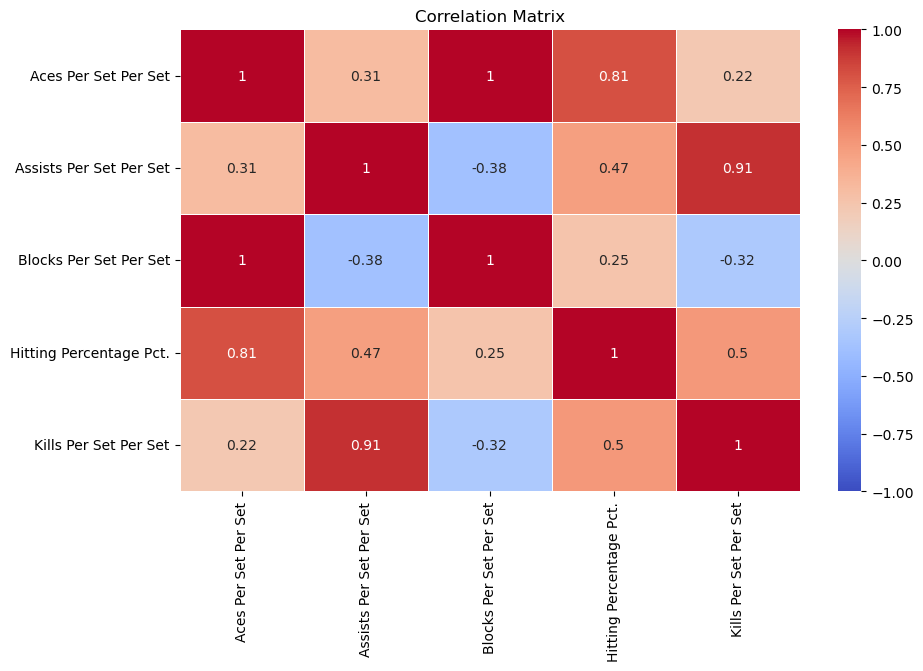

In [15]:
# Load the data
data = pd.read_csv('team_stats_combined.csv')
# After confirming the columns, select relevant ones for correlation
columns = [
    'Aces Per Set Per Set', 'Assists Per Set Per Set', 'Blocks Per Set Per Set',
     'Hitting Percentage Pct.', 'Kills Per Set Per Set'
]
data_selected = data[columns]

# Compute the correlation matrix
correlation_matrix = data_selected.corr()


# Create a heatmap for better visualization
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


### Heatmap Analysis

1. **Strong Positive Correlations**:
   - **Kills & Assists (0.91)**: Higher kills are closely tied to more assists.
   - **Aces & Hitting Percentage (0.81)**: Better serving aligns with hitting efficiency.

2. **Moderate Positive Correlations**:
   - **Hitting Percentage & Kills (0.50)**: Efficient hitting supports higher kills.
   - **Hitting Percentage & Assists (0.47)**: Effective assists improve hitting success.

3. **Negative Correlations**:
   - **Blocks & Assists (-0.38)**: More defensive blocks slightly reduce assist focus.
   - **Blocks & Kills (-0.32)**: Blocks inversely relate to kills, showing a balance between offense and defense.

4. **Low/No Correlation**:
   - **Aces & Kills (0.22)**: Minimal link between serving and kills.
   - **Aces & Blocks**: No significant relationship.

### Summary
Offensive metrics (kills, assists, hitting %) are strongly interconnected, while blocks (defensive) show an inverse relationship with some offensive stats.
